In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [62]:
input_location = 'KTH-alloc-only'
files_prefix = ''
# schedule_names = ['filler', 'balance-largest-1', 'balance-smallest-1', 'balance-ratio-1', 'backfill-1', 'no-reserve-1', 'fcfs']
schedule_names = ['filler', 'backfill-1', 'no-reserve-1', 'fcfs']

In [63]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-alloc-only/backfill-1_schedule.csv', '../output/KTH-alloc-only/balance-largest-1_schedule.csv', '../output/KTH-alloc-only/balance-ratio-1_schedule.csv', '../output/KTH-alloc-only/balance-smallest-1_schedule.csv', '../output/KTH-alloc-only/fcfs_schedule.csv', '../output/KTH-alloc-only/filler_schedule.csv', '../output/KTH-alloc-only/no-reserve-1_schedule.csv']
['../output/KTH-alloc-only/backfill-1_jobs.csv', '../output/KTH-alloc-only/balance-largest-1_jobs.csv', '../output/KTH-alloc-only/balance-ratio-1_jobs.csv', '../output/KTH-alloc-only/balance-smallest-1_jobs.csv', '../output/KTH-alloc-only/fcfs_jobs.csv', '../output/KTH-alloc-only/filler_jobs.csv', '../output/KTH-alloc-only/no-reserve-1_jobs.csv']


In [64]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df = df.set_index('schedule')
        metrics = metrics.append(df)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [65]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [86]:
metrics.index.rename(None, inplace=True)
metrics = metrics.reindex(schedule_names)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [80]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'allocated_resources']].apply(lambda row: row.execution_time * len(row.allocated_resources), axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [81]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [82]:
metrics.T

,filler,backfill-1,no-reserve-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88366e+07,2.87804e+07,3.49771e+07,3.81246e+07
max_slowdown,165776,202891,1.65383e+06,9.26291e+06
max_turnaround_time,4.73398e+06,645295,2.74739e+07,9.50694e+06
max_waiting_time,4.7199e+06,581791,2.74738e+07,9.43709e+06
mean_slowdown,241.819,276.146,3151.68,148759
mean_turnaround_time,29072.5,23782.2,544187,5.66148e+06
mean_waiting_time,20219.3,14929,535333,5.65263e+06
nb_computing_machines,109,109,109,109


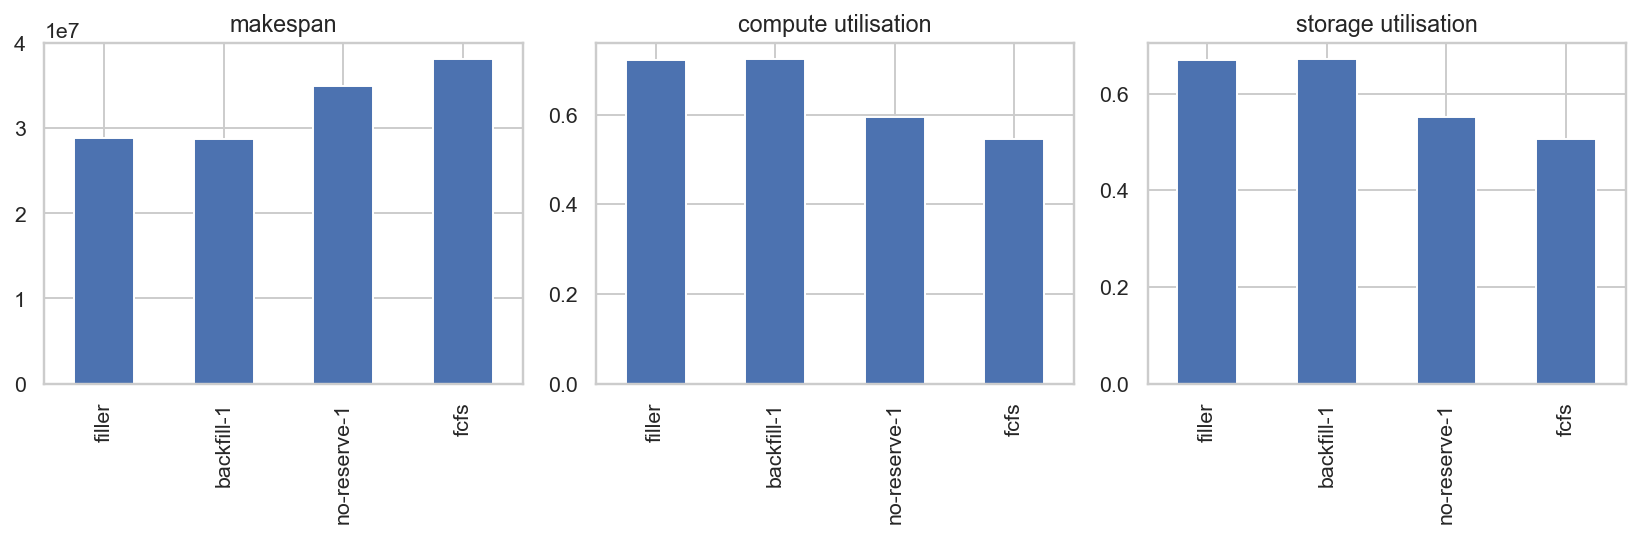

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=140)
metrics['makespan'].plot.bar(title='makespan', ax=axes[0])
metrics['compute_utilisation'].plot.bar(title='compute utilisation', ax=axes[1])
metrics['storage_utilisation'].plot.bar(title='storage utilisation', ax=axes[2])
fig.tight_layout()

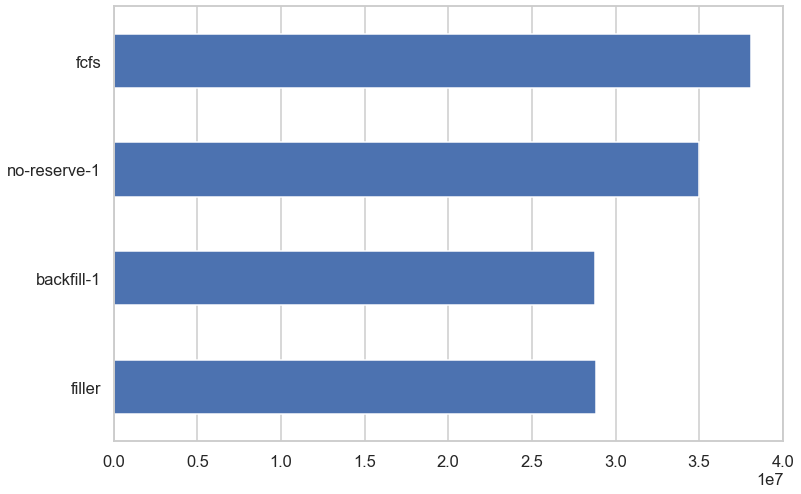

In [90]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

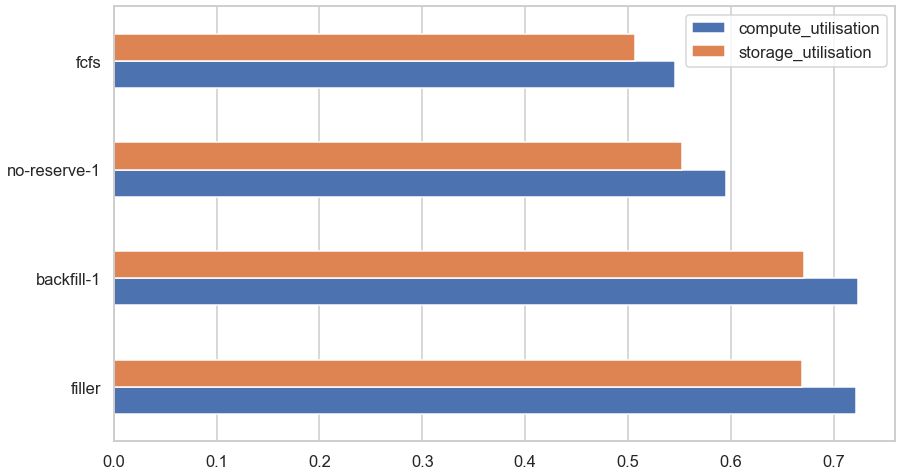

In [91]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [126]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.022923e+04,14936.336898,5.355967e+05,5.655411e+06
std,1.363842e+05,40351.526606,2.961573e+06,2.822758e+06
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,1.590251e+02,3.290391e+06
50%,0.000000e+00,74.000300,9.212011e+03,6.308759e+06
75%,4.556002e+03,10499.073028,5.006208e+04,8.067333e+06
max,4.719901e+06,581791.016150,2.747382e+07,9.437093e+06


(0.0, 28847510.274532948)

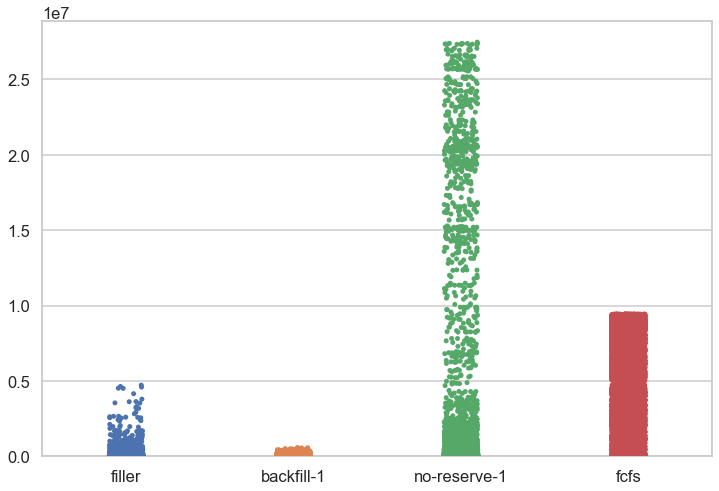

In [181]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0)

(11100.25859263489, 10000000)

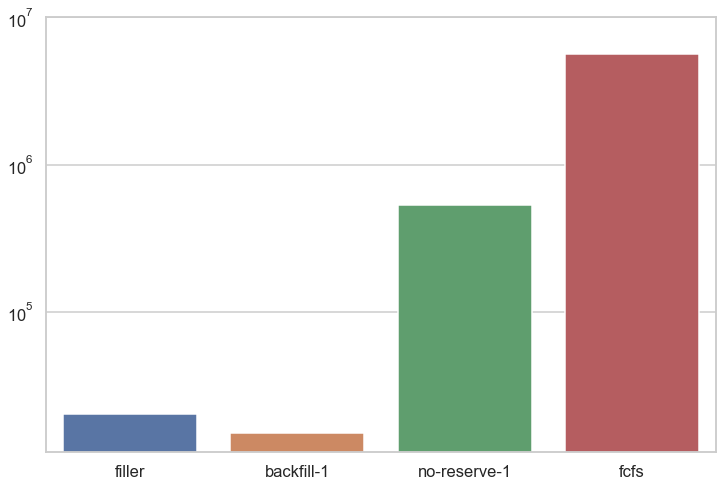

In [206]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(0.0, 131103.1727208)

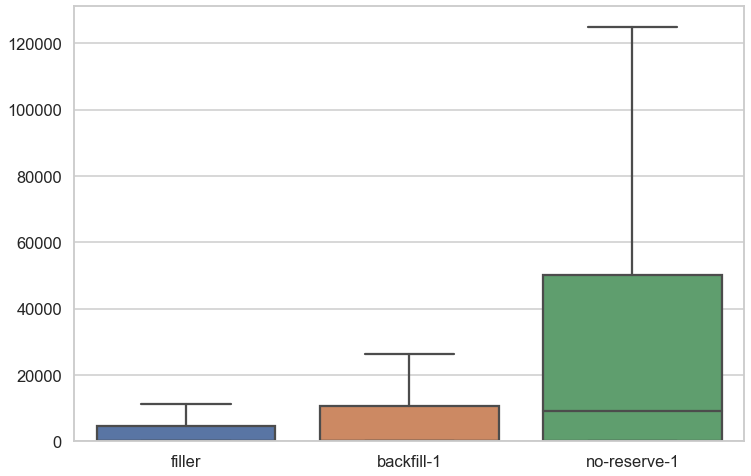

In [197]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=waiting_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [127]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.908680e+04,23793.916896,5.444543e+05,5.664269e+06
std,1.379345e+05,47628.384835,2.961693e+06,2.823932e+06
min,1.000000e+00,1.000000,1.000000e+00,2.000100e+00
25%,2.290003e+02,300.000000,3.690000e+03,3.300928e+06
50%,5.095001e+03,6383.000000,1.799800e+04,6.313491e+06
75%,2.009200e+04,26174.865404,6.664400e+04,8.072191e+06
max,4.733983e+06,645295.004500,2.747394e+07,9.506940e+06


(0.0, 28847639.37484795)

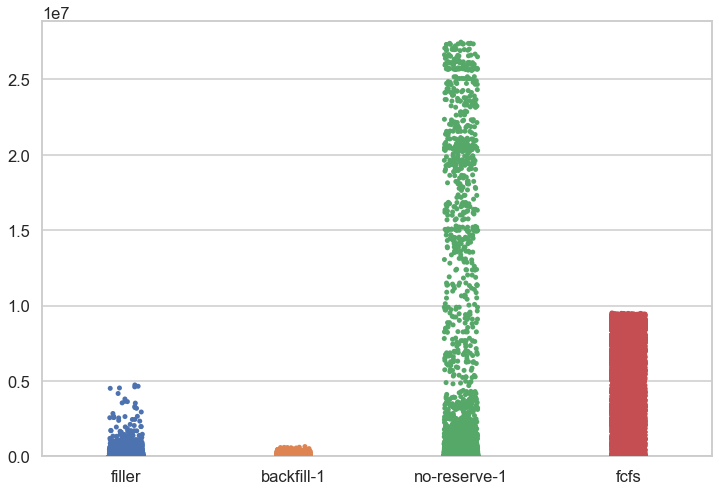

In [135]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0)

(18098.06086921502, 10000000)

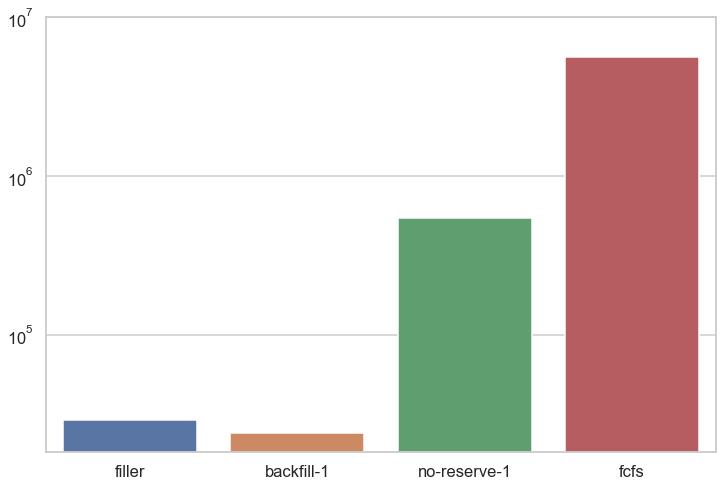

In [204]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(0.0, 169125.70094065001)

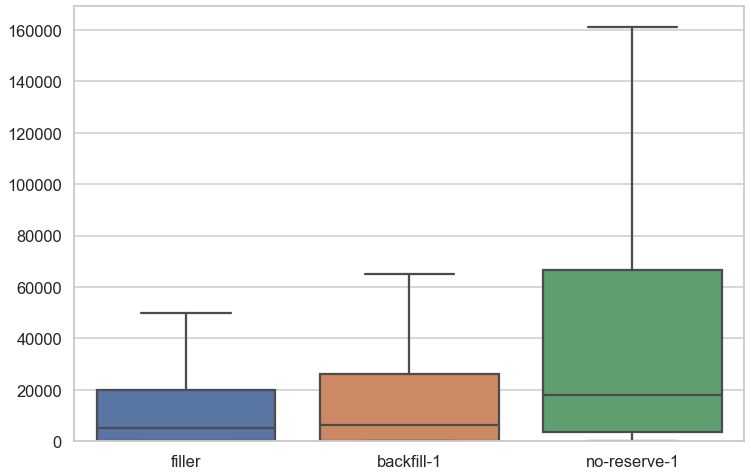

In [201]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=turnaround_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [136]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,241.937698,276.281974,3.153235e+03,1.488318e+05
std,2253.940419,2524.991508,2.510793e+04,5.322195e+05
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,1.000000,1.000000,1.042310e+00,5.729424e+02
50%,1.000000,1.034806,6.433531e+00,5.066495e+03
75%,4.377905,6.958020,2.068748e+02,9.584367e+04
max,165776.052878,202891.080026,1.653831e+06,9.262910e+06


(0.0, 9726055.6862332)

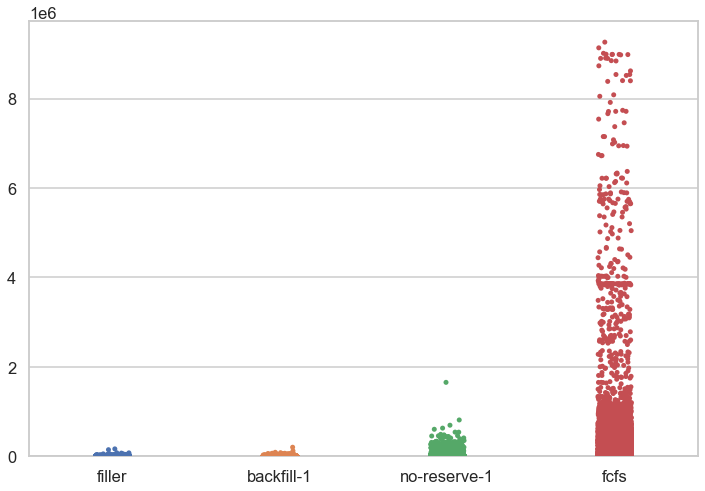

In [186]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0)

(175.49062845739942, 1000000)

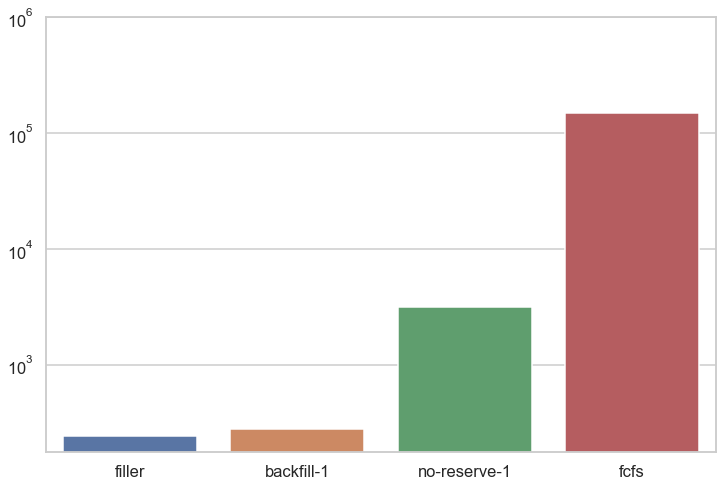

In [207]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=slowdown, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**6)

(0.0, 540.9433606)

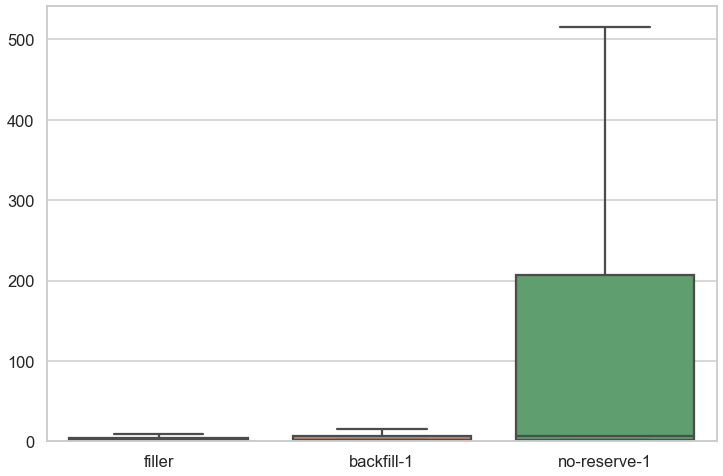

In [150]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=slowdown.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

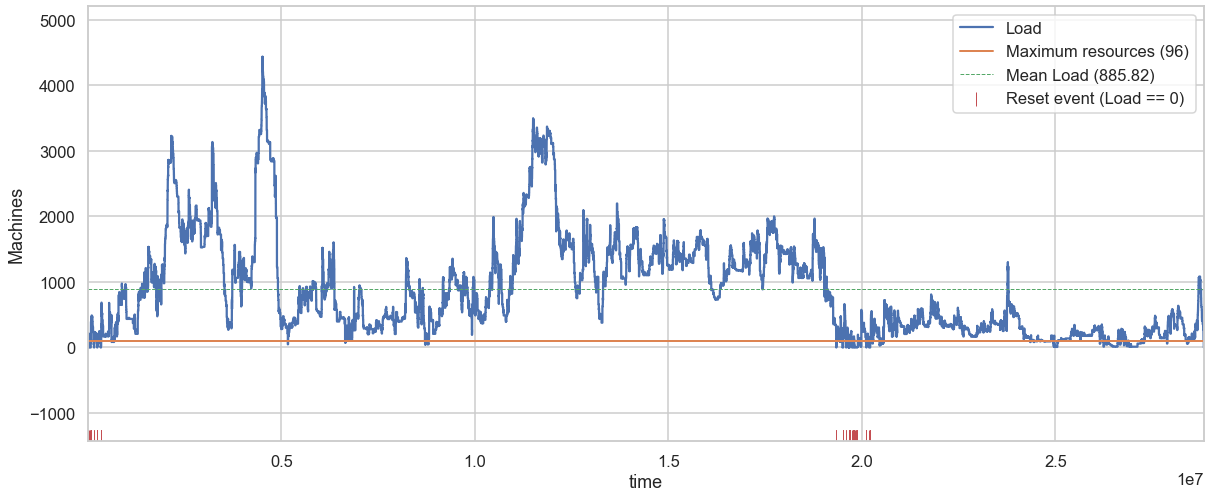

In [172]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

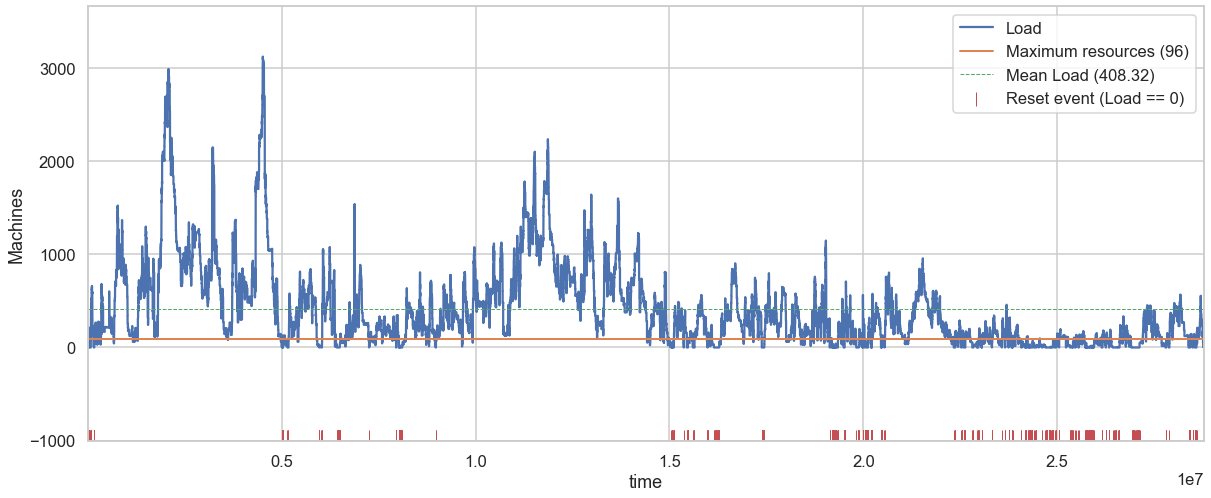

In [173]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

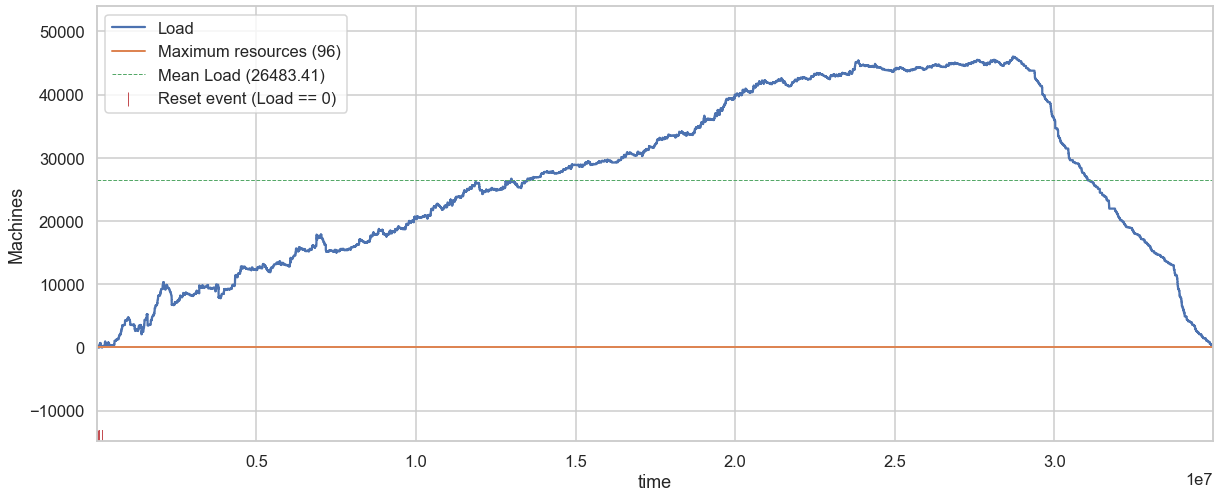

In [174]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['no-reserve-1'].queue, nb_resources=96, ax=ax)

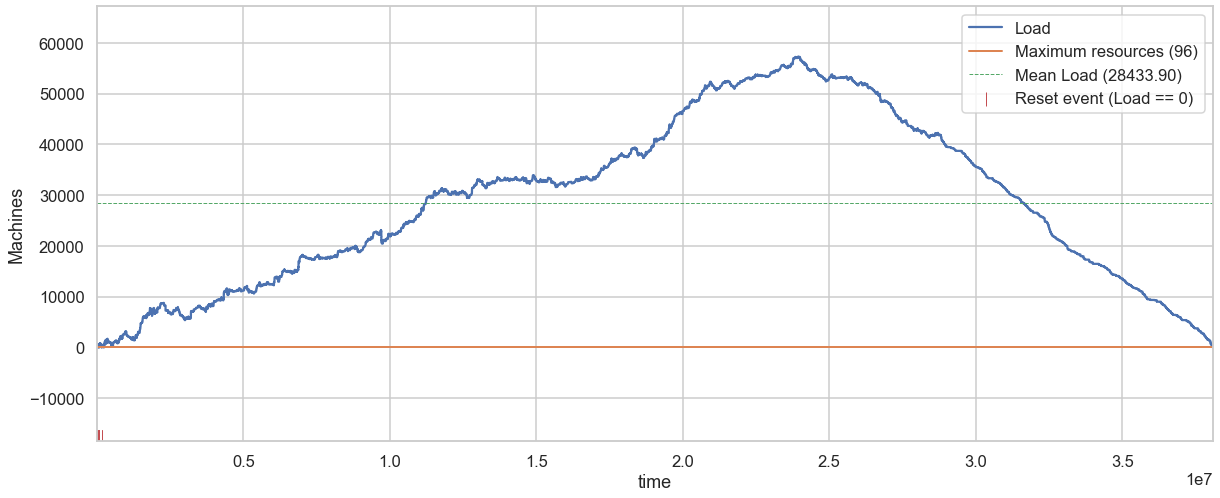

In [175]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)